# Solution

## Goal
Explain Simpson’s Paradox and show a concrete example where the *aggregate* comparison suggests one conclusion, but the *within-group* comparisons suggest another.

## Problem Statement
What is Simpson’s Paradox? Illustrate an example.

We’ll use this cost-per-click (CPC) dataset comparing the U.S. vs Japan across two search terms {cat, dog}.

At the **country (aggregate)** level, Japan appears more expensive ($6/click) than the U.S. ($2/click).

At the **country × search-term** level, the story changes:
- For **cat**, Japan is more expensive ($9 vs $2).
- For **dog**, Japan is cheaper ($1.50 vs $2).

This apparent reversal is Simpson’s Paradox.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Reproducibility (used for the optional synthetic example below)
np.random.seed(42)

plt.style.use("seaborn-v0_8")

## Key idea (why the paradox happens)
Simpson’s Paradox occurs when a third variable (a **confounder**) changes the mix of observations across groups, so that an **aggregate** comparison becomes a *weighted average* of subgroup comparisons with **different weights**.

In this example, the confounder is the **search term**. Each country has a different click mix across terms, and the terms have very different CPCs.

### What to look for
- Compute the overall CPC by country (aggregate).
- Compute CPC by country **within each term** (stratified).
- Compare the *weights* (click shares) each country assigns to each term.

In [8]:
# --- Input data from the prompt ---
by_term = pd.DataFrame(
    [
        {"country": "U.S.", "term": "cat", "clicks": 200, "cost": 400},
        {"country": "U.S.", "term": "dog", "clicks": 800, "cost": 1600},
        {"country": "Japan", "term": "cat", "clicks": 300, "cost": 2700},
        {"country": "Japan", "term": "dog", "clicks": 200, "cost": 300},
    ]
).assign(cpc=lambda d: d["cost"] / d["clicks"])

by_term


,country,term,clicks,cost,cpc
0,U.S.,cat,200,400,2.0
1,U.S.,dog,800,1600,2.0
2,Japan,cat,300,2700,9.0
3,Japan,dog,200,300,1.5


## Aggregate vs within-term comparisons
The aggregate CPC for a country is:

$$\text{CPC}_{\text{country}} = \frac{\sum_{t} \text{Cost}_{t}}{\sum_{t} \text{Clicks}_{t}} = \sum_{t} w_t \cdot \text{CPC}_{t}$$

where $w_t = \frac{\text{Clicks}_t}{\sum_t \text{Clicks}_t}$ is the click share (the weight).

So if two countries have different $w_t$ across terms, their aggregate CPCs can differ in a way that hides (or even reverses) the within-term story.

In [9]:
# Aggregate (country-level) CPC
by_country = (
    by_term.groupby("country", as_index=False)
    .agg(clicks=("clicks", "sum"), cost=("cost", "sum"))
    .assign(cpc=lambda d: d["cost"] / d["clicks"])
)
display(by_country)

# Within-term CPC comparison
within_term = by_term.pivot(index="term", columns="country", values="cpc")
within_term["Japan_minus_US"] = within_term["Japan"] - within_term["U.S."]
display(within_term)

# Term mix (weights) by country
weights = by_term.copy()
weights["click_share"] = weights["clicks"] / weights.groupby("country")["clicks"].transform("sum")
display(weights[["country", "term", "clicks", "click_share", "cpc"]].sort_values(["country", "term"]))

# Verify: aggregate CPC is a weighted average of term CPCs
weighted_check = (
    weights.assign(weighted_cpc=lambda d: d["click_share"] * d["cpc"])
    .groupby("country", as_index=False)
    .agg(weighted_avg_cpc=("weighted_cpc", "sum"))
)
display(weighted_check.merge(by_country[["country", "cpc"]], on="country").rename(columns={"cpc": "aggregate_cpc"}))

,country,clicks,cost,cpc
0,Japan,500,3000,6.0
1,U.S.,1000,2000,2.0


country,Japan,U.S.,Japan_minus_US
term,,,
cat,9.0,2.0,7.0
dog,1.5,2.0,-0.5


,country,term,clicks,click_share,cpc
2,Japan,cat,300,0.6,9.0
3,Japan,dog,200,0.4,1.5
0,U.S.,cat,200,0.2,2.0
1,U.S.,dog,800,0.8,2.0


,country,weighted_avg_cpc,aggregate_cpc
0,Japan,6.0,6.0
1,U.S.,2.0,2.0


## Visualization
We’ll plot CPC by country for each term, alongside the aggregate CPC.

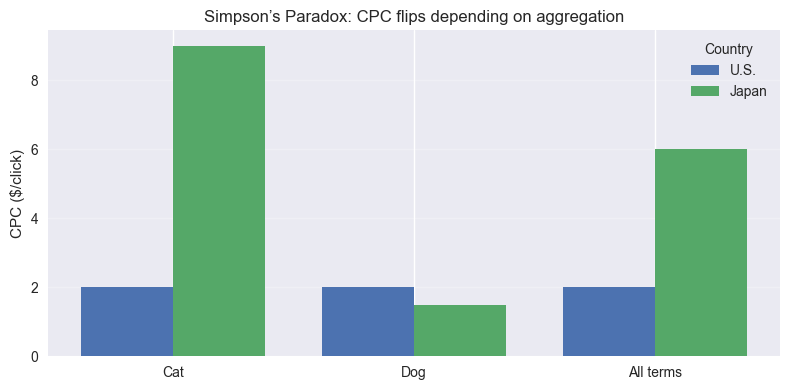

In [10]:
# Prepare data for plotting
plot_term = by_term.copy()
plot_term["label"] = plot_term["term"].str.title()

plot_country = by_country.copy()
plot_country["label"] = "All terms"

plot_df = pd.concat(
    [
        plot_term[["country", "label", "cpc"]],
        plot_country[["country", "label", "cpc"]],
    ],
    ignore_index=True,
 )

# Bar chart: CPC by term (and overall) per country
labels = ["Cat", "Dog", "All terms"]
countries = ["U.S.", "Japan"]

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(labels))
width = 0.38

for i, country in enumerate(countries):
    y = (
        plot_df.loc[plot_df["country"] == country]
        .set_index("label")
        .reindex(labels)["cpc"]
        .astype(float)
        .to_numpy()
    )
    ax.bar(x + (i - 0.5) * width, y, width, label=country)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("CPC ($/click)")
ax.set_title("Simpson’s Paradox: CPC flips depending on aggregation")
ax.legend(title="Country")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

## (Optional) Extra example: A/B testing segment mix
This toy example shows how a variant can look better in *each* segment but worse overall if the segment mix differs between variants (a classic Simpson’s Paradox pattern).

In [11]:
ab = pd.DataFrame(
    [
        # Variant A gets mostly high-converting Chrome traffic
        {"variant": "A", "segment": "Chrome", "users": 200, "conversions": 180},
        {"variant": "A", "segment": "Safari", "users": 20, "conversions": 2},
        # Variant B is better within each segment, but gets mostly low-converting Safari traffic
        {"variant": "B", "segment": "Chrome", "users": 20, "conversions": 19},
        {"variant": "B", "segment": "Safari", "users": 200, "conversions": 22},
    ]
).assign(rate=lambda d: d["conversions"] / d["users"])

display(ab)

# Within-segment comparison
within = ab.pivot(index="segment", columns="variant", values="rate")
within["B_minus_A"] = within["B"] - within["A"]
display(within)

# Aggregate comparison
overall = (
    ab.groupby("variant", as_index=False)
    .agg(users=("users", "sum"), conversions=("conversions", "sum"))
    .assign(rate=lambda d: d["conversions"] / d["users"])
)
display(overall)

,variant,segment,users,conversions,rate
0,A,Chrome,200,180,0.90
1,A,Safari,20,2,0.10
2,B,Chrome,20,19,0.95
3,B,Safari,200,22,0.11


variant,A,B,B_minus_A
segment,,,
Chrome,0.9,0.95,0.05
Safari,0.1,0.11,0.01


,variant,users,conversions,rate
0,A,220,182,0.827273
1,B,220,41,0.186364


## Practical implication (A/B testing)
A common real-world manifestation is experiment readouts:
- You may see a lift in the primary metric **overall**.
- But the lift can differ materially by segment (browser, device, geography, acquisition channel, etc.).
- If segment mixes differ between variants (or over time), an overall result can be misleading.

A good default habit: always review key segments (and consider a model/analysis that adjusts for the confounder) before rolling out globally.

## Practical checklist
- Identify plausible confounders (variables that affect both group membership and the outcome).
- Compare aggregates *and* stratified results on key confounders.
- Inspect segment weights (mix shifts): are you comparing like-for-like?
- Decide the “right” estimand for the decision (unadjusted vs adjusted).
- When in doubt, run sensitivity checks and collect more data.

## Conclusion
Simpson’s Paradox is a reminder that aggregates are weighted averages. If the weights differ across groups, the aggregate comparison can hide or reverse the subgroup story—so segment-aware analysis is often essential.